In [1]:
# this sets up basic packages
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.cosmology.units as cu

# this sets up matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
#plt.rcParams['font.family'] = 'serif'
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# this sets up astropy
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel, proj_plane_pixel_scales
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky, Distance
from astropy.cosmology import Planck15 as cosmo

from astropy.nddata import Cutout2D
from regions import PixCoord, Regions, CircleSkyRegion, CirclePixelRegion, TextSkyRegion, RegionVisual

from astropy.visualization import make_lupton_rgb

In [2]:
# this is the name of the catalog file compiled by Hollis
large_catalog = '/Users/ngbinh/Downloads/COSMOS-Web_supercatalog_v0.7.fits'

In [3]:
# this opens the HDU list of the .fits files and asks for the information within. SCI is what we'll use
hdu_list = fits.open(large_catalog)
hdu_list.info()

# this saves the WCS setting to be used later
wcs = WCS(hdu_list[1].header)

Filename: /Users/ngbinh/Downloads/COSMOS-Web_supercatalog_v0.7.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    802   913253R x 155C   [K, D, D, 3A, D, 4A, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, D, D, D, D, D, D, D, D, 5D, 5D, 5D, L, K, E, E, K, L, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, L, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [4]:
# this gets the data of the catalog. "cat" stands for catalog!
cat_data = hdu_list[1].data

In [5]:
# closes the data file
hdu_list.close()

In [6]:
# get all the essential info for comparison from the previously opened catalog
ra = cat_data['ra']
dec = cat_data['dec']
tile = cat_data['tile']
z_spec = cat_data['z_spec']

In [7]:
# now read in the RAs and Decs of our 9 galaxies to match them to Hollis's table
info = np.genfromtxt('basic_data.txt', delimiter=' ', dtype=['U15', '<f8','<f8', '<f8'])
print(info)

[('Hong', 150.06149 , 2.37868  , 3.715)
 ('Bach-Dang', 150.11256 , 2.3765266, 2.474)
 ('Gianh', 150.06671 , 2.3823645, 3.715)
 ('Ben-Hai', 150.08728 , 2.3960431, 3.782)
 ('Huong-Giang', 150.43732 , 2.46392  , 3.336)
 ('Thu-Bon', 150.45459 , 2.455994 , 3.757)
 ('Dong-Nai', 150.4612  , 2.429547 , 4.673)
 ('Saigon', 150.106932, 2.377961 , 4.57 )
 ('Tien', 150.108873, 2.330539 , 3.238)]


In [8]:
# now we find the indices of our 9 galaxies in Hollis's table and locate the tiles they're in

### create an empty array to fill things in
galaxy_idx = np.zeros(np.size(info), dtype=int)
galaxy_ra = np.zeros(np.size(info), dtype=float)
galaxy_dec = np.zeros(np.size(info), dtype=float)
galaxy_redshift = np.zeros(np.size(info), dtype=float)

for i in range(np.size(info)):
    ### locate the index of the galaxy in question by matching RA and Dec
    ### the 1e-4 difference is to account for the fact that the RA and Dec are later rounded (I think?)
    ra_idx = np.where(np.abs(ra - info[i][1]) < 1e-4)
    dec_idx = np.where(np.abs(dec - info[i][2]) < 1e-4)
    galaxy_redshift[i] = info[i][3]
    idx = np.intersect1d(ra_idx, dec_idx)

    ### save the index into galaxy_idx
    galaxy_idx[i] = idx[0]

    ### save the more detailed ra and dec into separate arrays
    galaxy_ra[i] = ra[idx[0]]
    galaxy_dec[i] = dec[idx[0]]

In [9]:
# locate the tiles that our galaxies are in
our_tiles = tile[galaxy_idx]
our_zs = z_spec[galaxy_idx]

In [10]:
# Nov 15: find the info for Saigon and Tien to estimate their stellar masses with CIGALE
galaxy_idx[-2:]

array([758078, 799629])

In [11]:
cat_data[galaxy_idx[-2:]]['id']

array([758078, 799629], dtype='>i8')

In [12]:
# continue with the previous code

In [13]:
nircam_bands = np.array(['f115w', 'f150w', 'f277w', 'f444w'])
how_many_bands = np.size(nircam_bands)

In [14]:
# now get the redshifts from the data file
redshifts = np.zeros(np.size(info), dtype='float')
for i in range(np.size(info)):
    redshifts[i] = info[i][3]

In [15]:
angular_sizes = np.full((1, np.size(info)), 15)[0] * u.arcsec

In [16]:
# now read in the RAs and Decs of our potential neighbors
saved_nbrs = pd.read_csv('potential_neighbors.txt', sep='\t')

In [17]:
our_id_saved = pd.read_csv('neighbor_data.csv')[['id', 'our_id']]
full_data = pd.concat([pd.merge(our_id_saved, saved_nbrs, how='right', on='id') 
                    for dfe in [our_id_saved, saved_nbrs]], ignore_index=True).drop_duplicates()

### Sep 25, 2024: 

1. Make postage stamps of the 16 neighbors that didn't appear in either Marko's or Hollis's catalog (see the notebook called "catalog_checks" for more info).

In [19]:
# read in the RAs and Decs of the outliers
outliers = pd.read_csv('16_outliers.txt', sep='\t')

In [20]:
### matching coords
outliers_obj = SkyCoord(ra=outliers['ra'].values*u.degree, dec=outliers['dec'].values*u.degree)
catalog_obj = SkyCoord(ra=cat_data['ra']*u.degree, dec=cat_data['dec']*u.degree)

# use search_around_sky to find matching indices (matching in RA and Dec) in each catalog
idx_outliers, idx_cat, d2d, d3d = catalog_obj.search_around_sky(outliers_obj, 0.1*u.arcsec)

In [21]:
snr_f277w = []
snr_f444w = []

for cat_id in idx_cat:
    snr_f277w.append(cat_data[cat_id]['snr_f277w'])
    snr_f444w.append(cat_data[cat_id]['snr_f444w'])

In [22]:
outliers['snr_f227w'] = snr_f277w
outliers['snr_f444w'] = snr_f444w

In [23]:
cigale_results = fits.open('out_all998_renamed/results.fits')
# this gets the data from the results FITS file
cigale_data = Table(cigale_results[1].data).to_pandas()

In [24]:
# this creates a DataFrame with the RA and Dec of our good-fits neighbors
outliers_16_info = pd.merge(outliers, cigale_data.loc[cigale_data['id'].isin(idx_cat)], on="id", how="left")

In [25]:
outliers_16_info.to_csv('16_outliers.csv', index=False)

In [26]:
# create empty lists to save the tiles that contain the outliers
outlier_list = []
outlier_tile = []

2. Make postage stamps of the 25 neighbors that were flagged 1 in Olivier's LePhare catalog (see the notebook called "catalog_checks" for more info).

In [28]:
# read in the RAs and Decs of the outliers
lephare = pd.read_csv('25_flag1.txt', sep='\t')

In [29]:
### matching coords
lephare_obj = SkyCoord(ra=lephare['ra'].values*u.degree, dec=lephare['dec'].values*u.degree)

# use search_around_sky to find matching indices (matching in RA and Dec) in each catalog
idx_lephare, idx_cat2, d2d, d3d = catalog_obj.search_around_sky(lephare_obj, 0.05*u.arcsec)

In [30]:
idx_lephare, idx_cat2

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 array([756650, 780830, 780870, 756895, 783764, 758845, 783964, 759022,
        759045, 784079, 759140, 784159, 759202, 759207, 784266, 759334,
        784406, 759455, 759460, 784557, 784569, 784580, 784614, 784646,
        783888]))

In [31]:
snr_f277w_lephare = []
snr_f444w_lephare = []

for cat_id in idx_cat2:
    snr_f277w_lephare.append(cat_data[cat_id]['snr_f277w'])
    snr_f444w_lephare.append(cat_data[cat_id]['snr_f444w'])

In [32]:
lephare['snr_f277w'] = snr_f277w_lephare
lephare['snr_f444w'] = snr_f444w_lephare

In [33]:
# this creates a DataFrame with the RA and Dec of our good-fits neighbors
flag1_info = pd.merge(lephare, cigale_data.loc[cigale_data['id'].isin(idx_cat2)], on="id", how="left")

In [34]:
flag1_info.to_csv('25_flag1.csv', index=False)

In [35]:
# create empty lists to save the tiles that contain the LePhare objects flagged 1
lephare_list = []
lephare_tile = []

# Final Plots

Now, let's create the postage stamps. There are two types of postage stamps we're going to make. The first one is of the central galaxy and covers such a big radius that it encompasses all the neighbors of the central galaxy. The second one is a whole tableau of subplots, not just for the zoomed-in central galaxy but also for their neighbors. We're going to create both types of postage stamps as we loop over each of the 9 QGs.

In [37]:
# first, we read in the file that has all the robustly-checked galaxies
robust_df = pd.read_csv('robust_set.csv', index_col=None, usecols=[1, 2, 3, 4, 5, 6, 7, 8])

In [38]:
# create an empty frame to later add things into
sorted = pd.DataFrame()

# add data for all robust and non-robust neighbors of each galaxy
for galaxy in range(np.size(info)):
    all_data = full_data[full_data['our_id'] == galaxy]
    robust_data = robust_df[robust_df['our_id'] == galaxy]
    nonrobust_data = all_data.loc[all_data['id'].isin(robust_df['id'].values)==False] 

    # now, get the rows of data arranged by numerical order of catalog ID
    robust_sorted = robust_data.sort_values(by='id')
    nonrobust_sorted = nonrobust_data.sort_values(by='id')

    # now, add the data rows into the empty pandas frame for each galaxy
    both_types = pd.concat([robust_sorted, nonrobust_sorted])
    sorted = pd.concat([sorted, both_types])

In [39]:
sorted = sorted.fillna('NA')
sorted.to_csv('all_neighbors.csv', index=None)

Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-27T10:47:09.482' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.877923 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689690570.898 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-24T20:33:34.974' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.289' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-27T10:47:09.482' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.877923 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689690570.898 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-24T20:33:34.974' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.289' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-27T10:47:09.482' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.877923 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689690570.898 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-24T20:33:34.974' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.289' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-27T10:47:09.482' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.877923 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689690570.898 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-24T20:33:34.974' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.289' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B4_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B4_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B4_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2024-01-03T02:33:49.399' from MJD-AVG.
Set DATE-END to '2024-01-06T18:03:33.852' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.962298 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686149605.641 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-02T11:26:42.626' from MJD-AVG.
Set DATE-END to '2024-01-06T17:28:50.910' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     9.002883 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696586013.959 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-02T12:01:20.603' from MJD-AVG.
Set DATE-END to '2024-01-06T18:03:33.852' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.998031 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696584712.167 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B5_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B5_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B5_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2024-01-01T14:04:49.430' from MJD-AVG.
Set DATE-END to '2024-01-06T20:41:43.955' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.887810 from OBSGEO-[XYZ].
Set OBSGEO-H to 1695623362.790 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-01T17:28:21.465' from MJD-AVG.
Set DATE-END to '2024-01-06T20:06:50.261' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     9.002883 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696586013.959 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-01T18:03:01.413' from MJD-AVG.
Set DATE-END to '2024-01-06T20:41:43.955' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     9.004838 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696585931.786 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B5_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B5_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B5_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2024-01-01T14:04:49.430' from MJD-AVG.
Set DATE-END to '2024-01-06T20:41:43.955' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.887810 from OBSGEO-[XYZ].
Set OBSGEO-H to 1695623362.790 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-01T17:28:21.465' from MJD-AVG.
Set DATE-END to '2024-01-06T20:06:50.261' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     9.002883 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696586013.959 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-01T18:03:01.413' from MJD-AVG.
Set DATE-END to '2024-01-06T20:41:43.955' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     9.004838 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696585931.786 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-27T10:47:09.482' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.877923 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689690570.898 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-24T20:33:34.974' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.289' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B8_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B8_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B8_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   


Set DATE-AVG to '2023-12-17T00:49:53.682' from MJD-AVG.
Set DATE-END to '2024-01-06T19:05:22.649' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.941421 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696374654.240 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-12-04T06:52:06.528' from MJD-AVG.
Set DATE-END to '2024-01-06T18:30:50.458' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.940522 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696367709.229 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-12-06T20:13:01.371' from MJD-AVG.
Set DATE-END to '2024-01-06T19:05:22.649' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


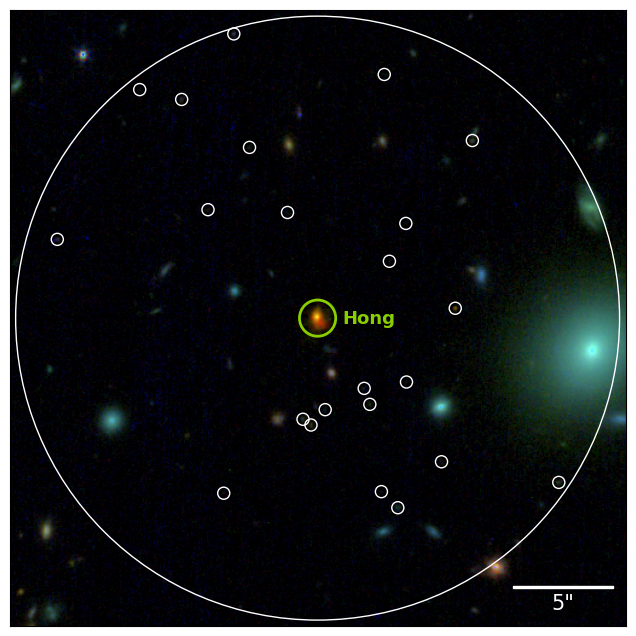

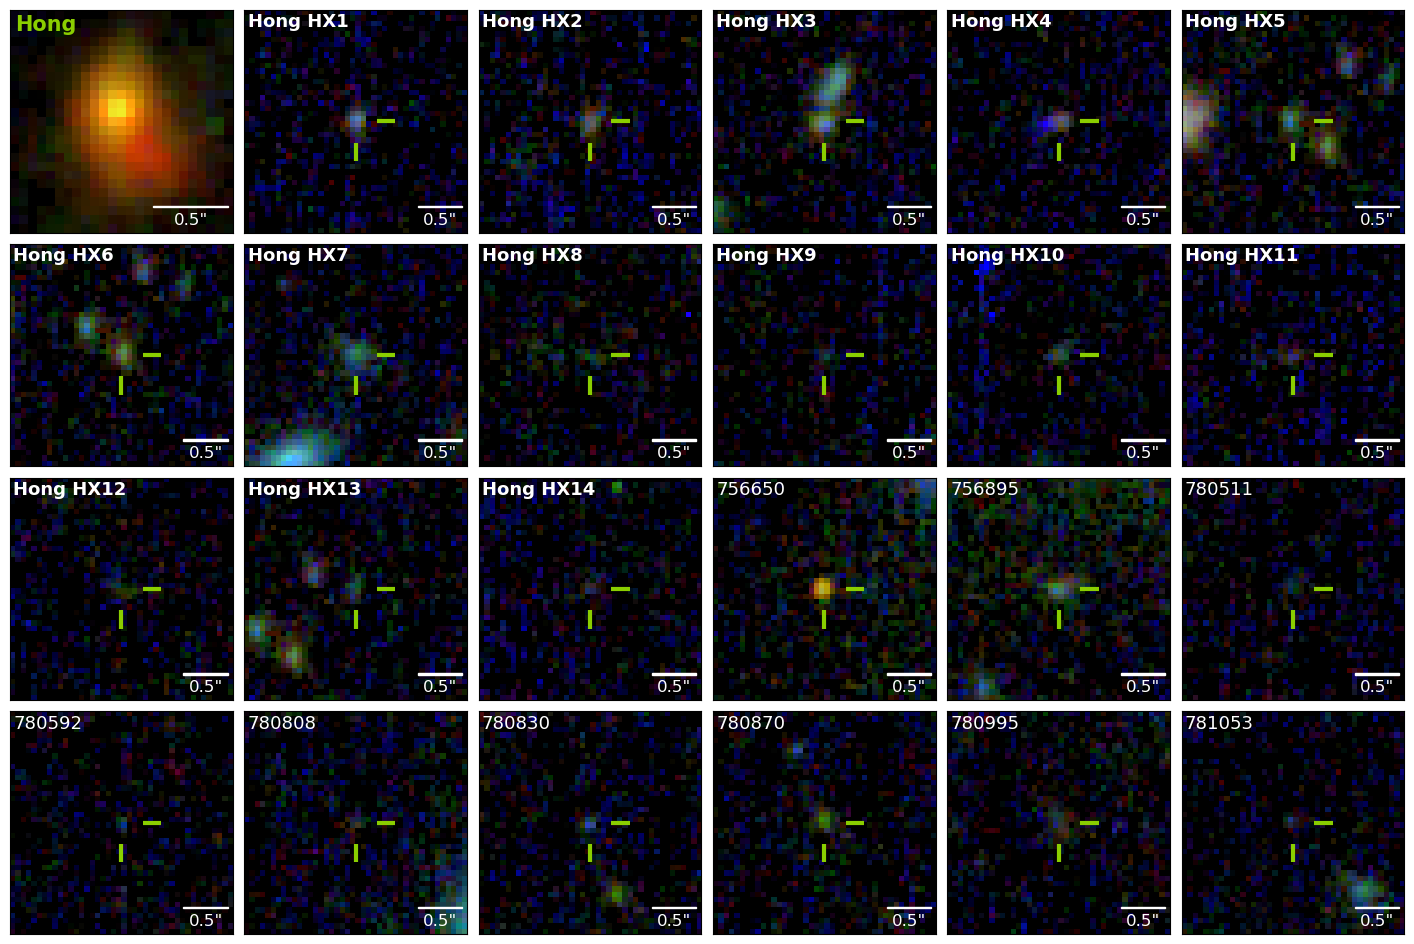

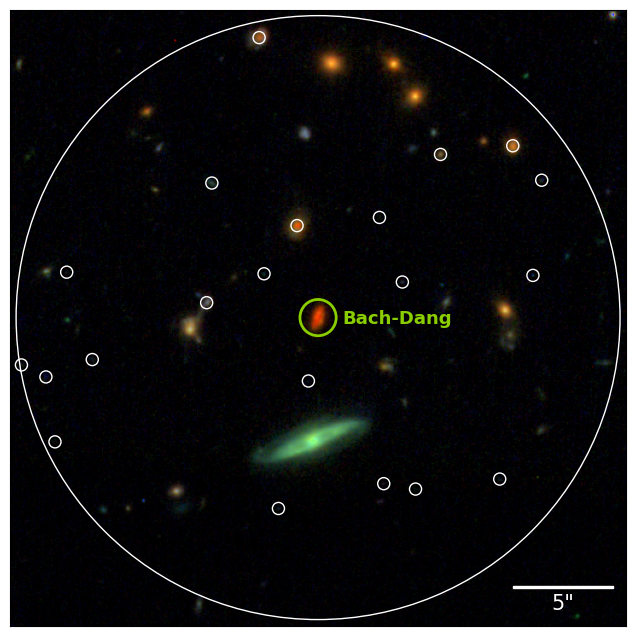

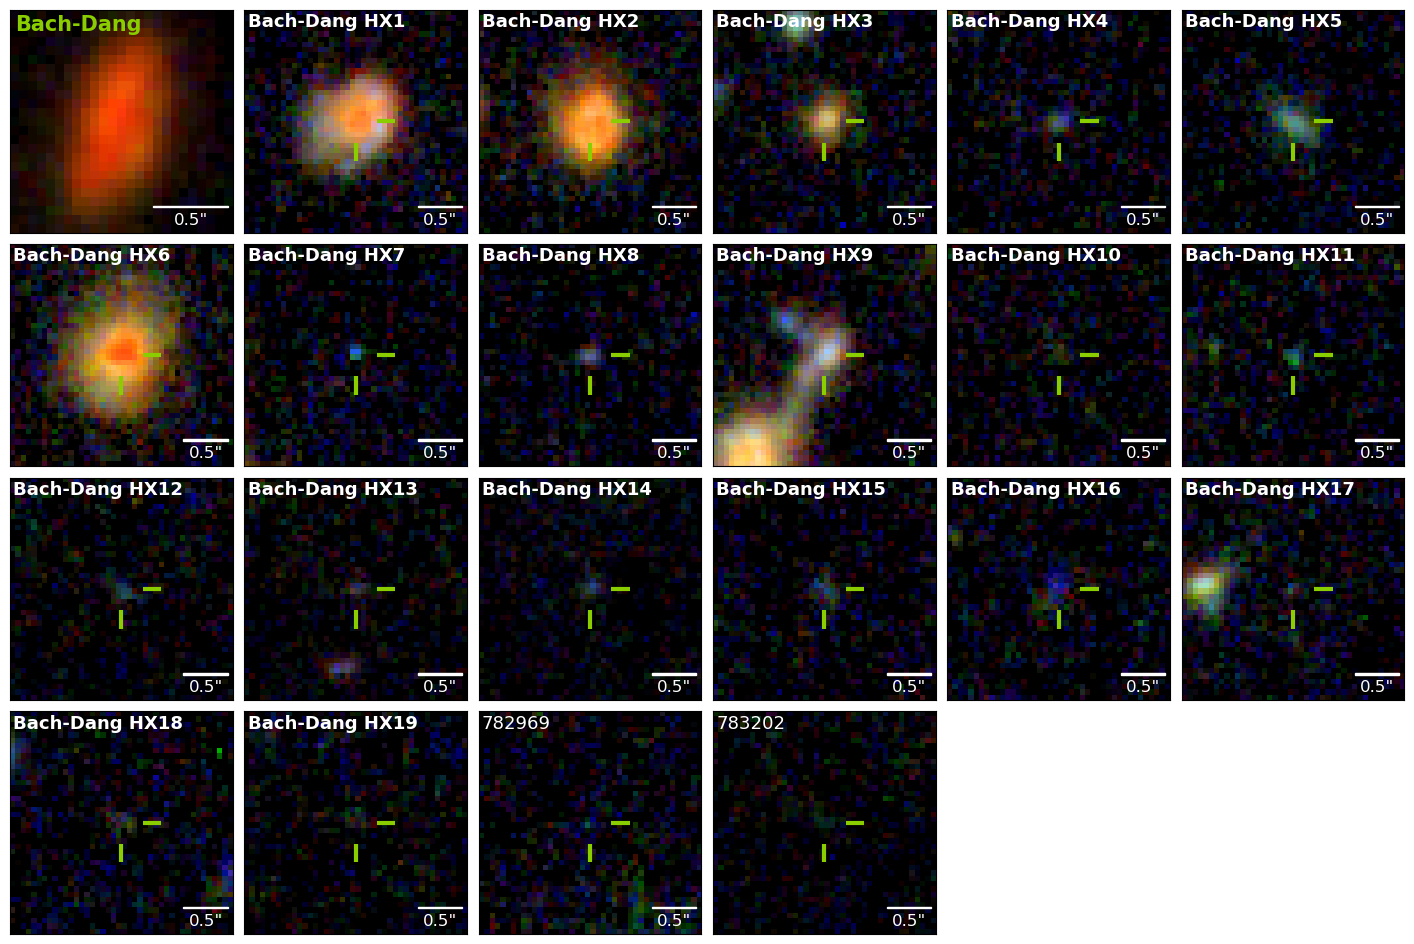

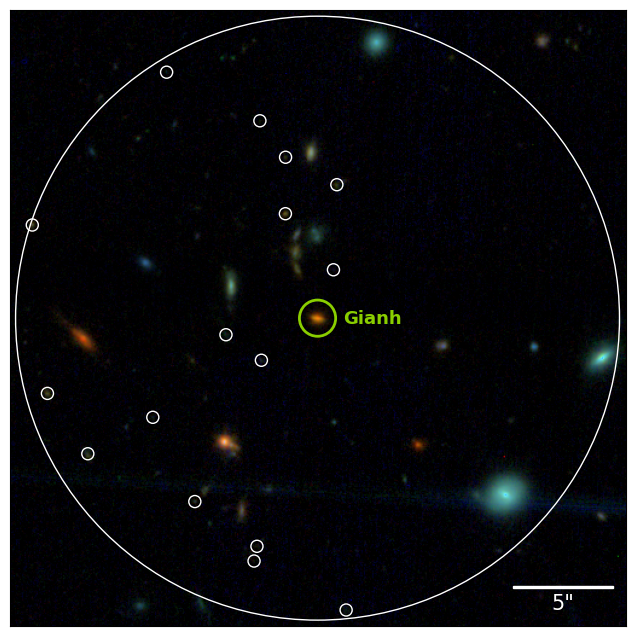

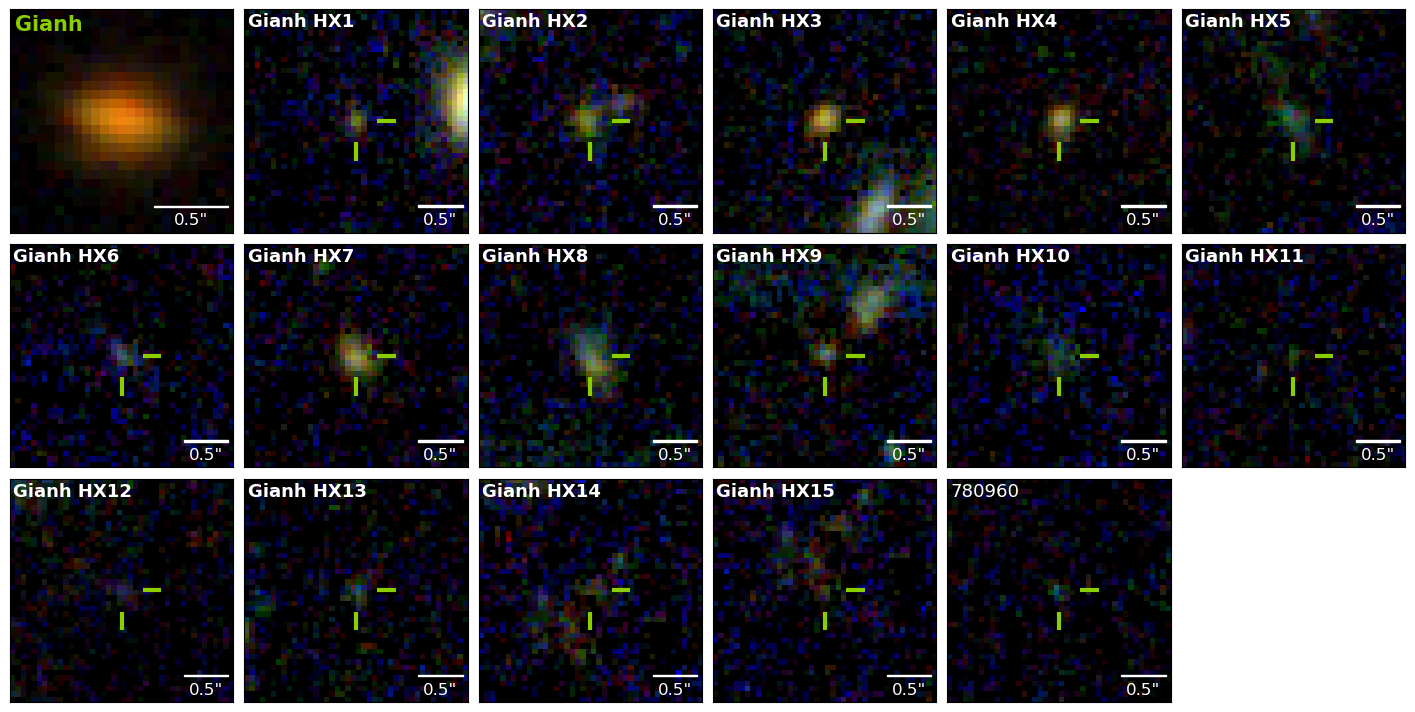

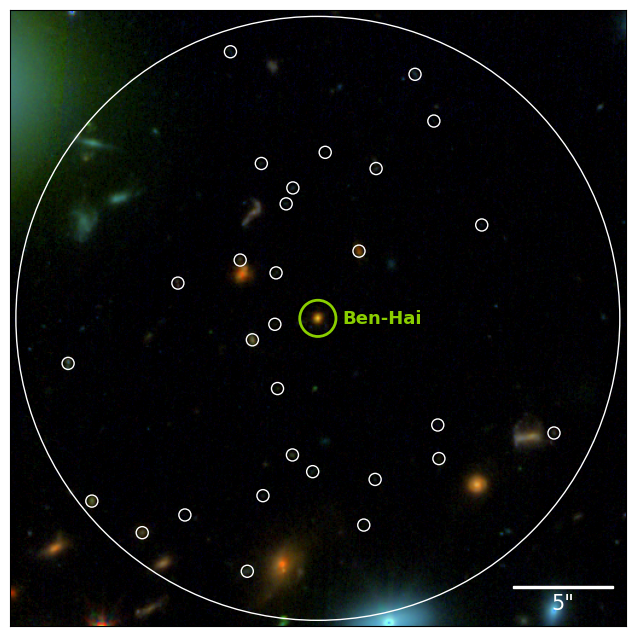

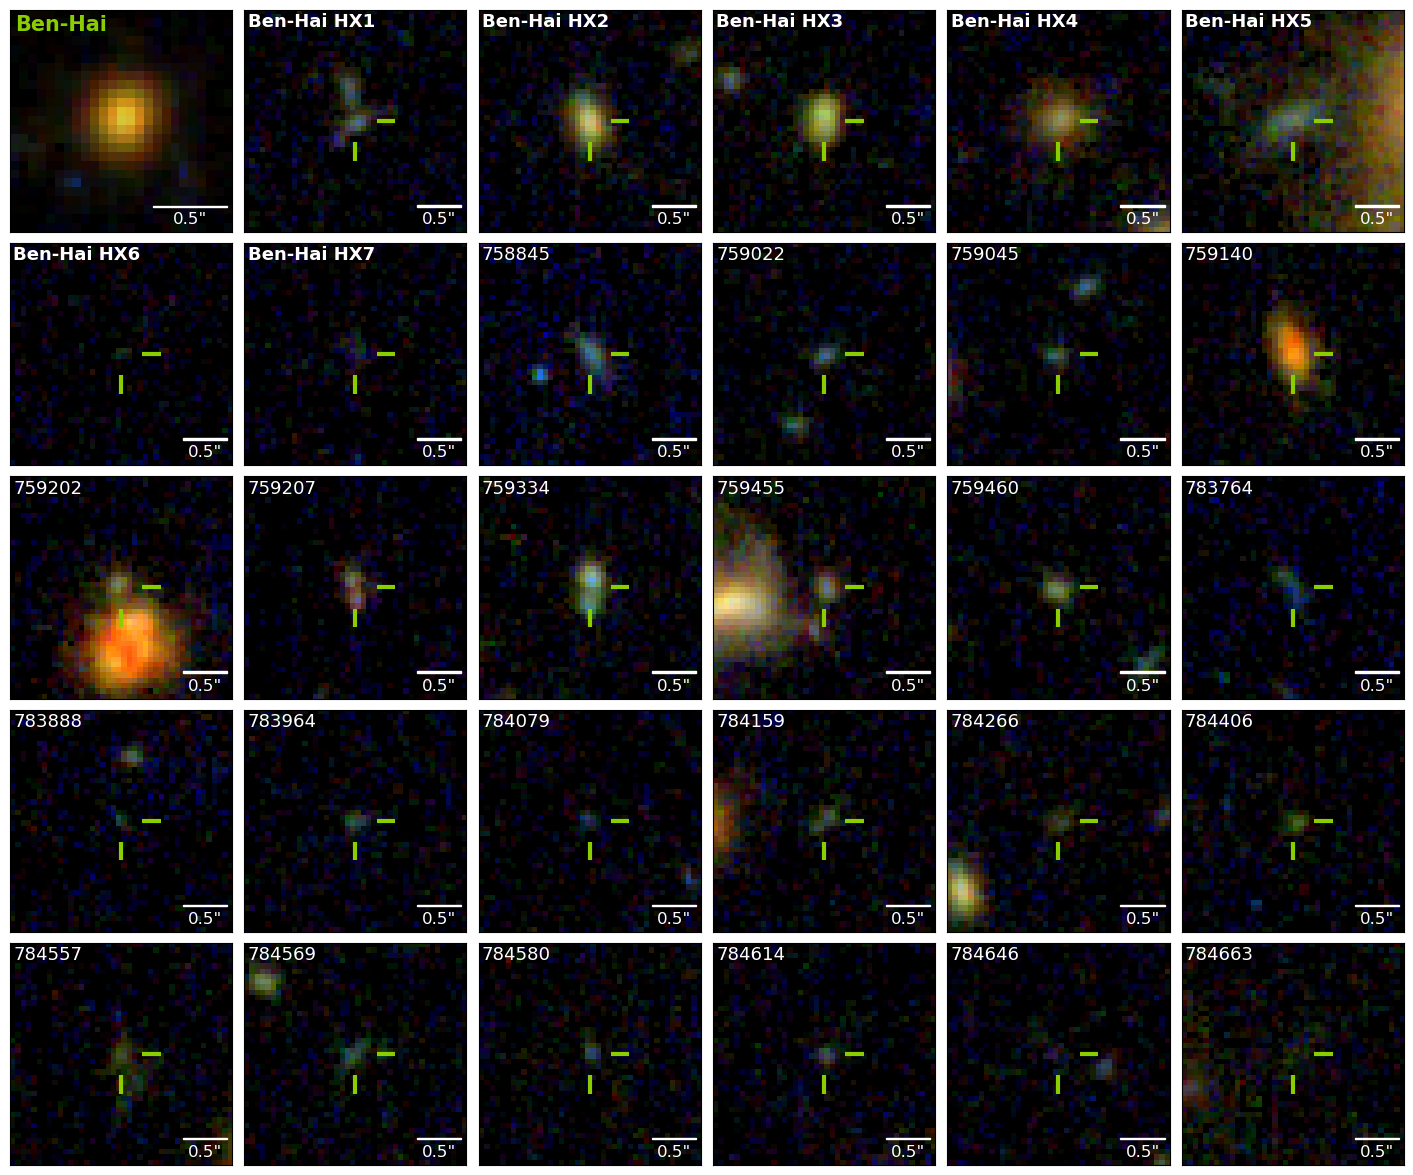

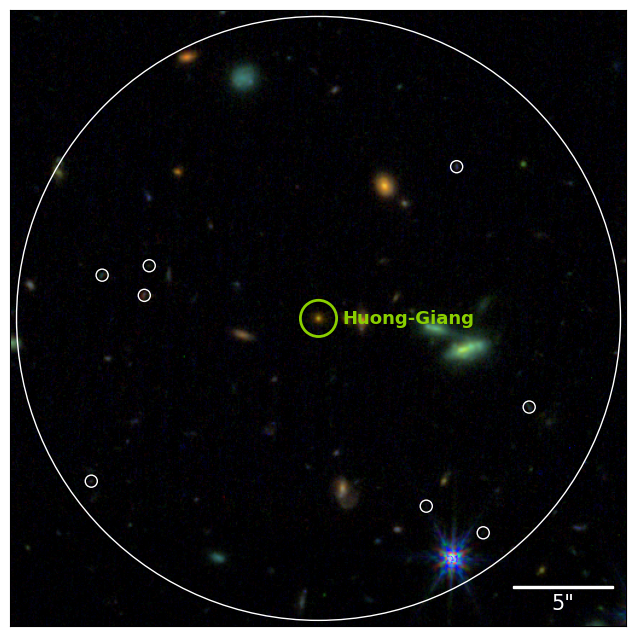

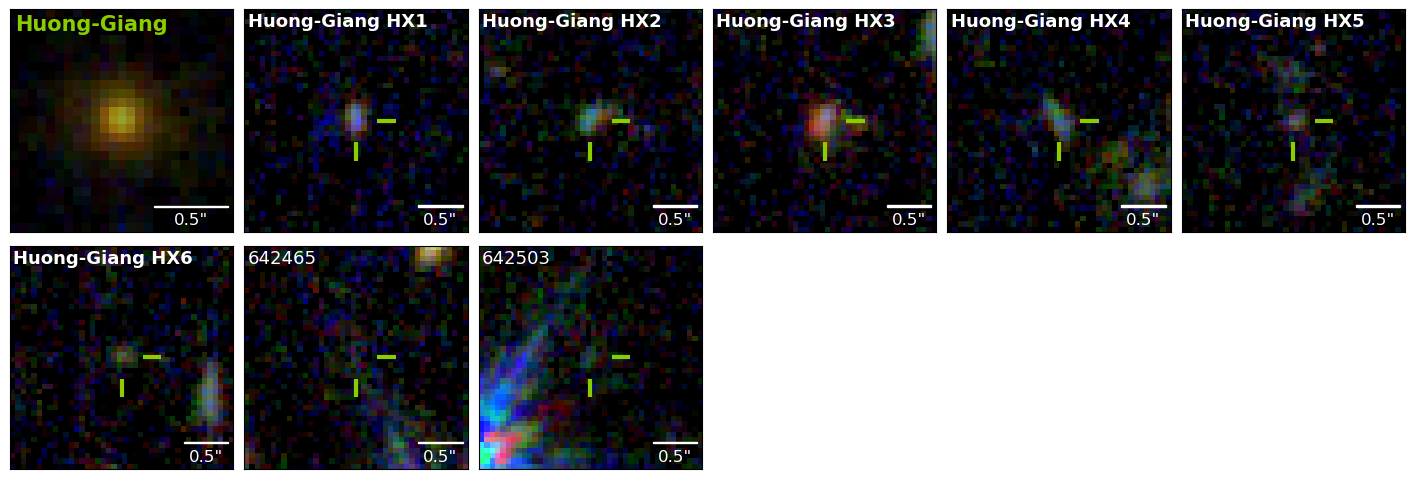

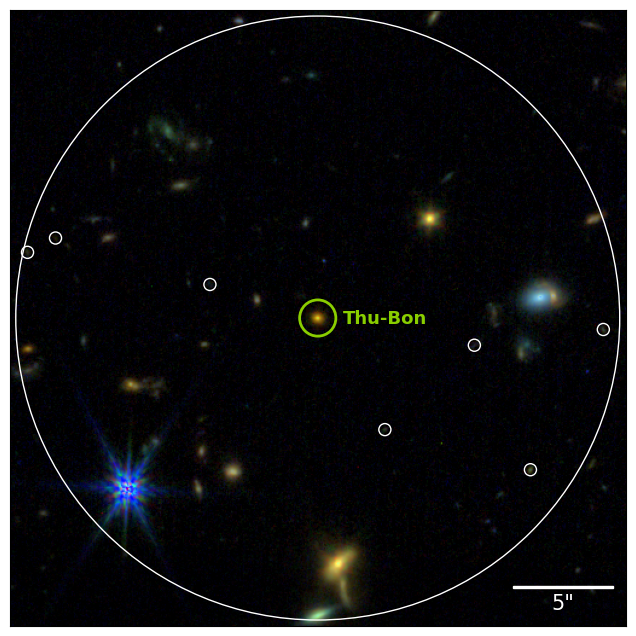

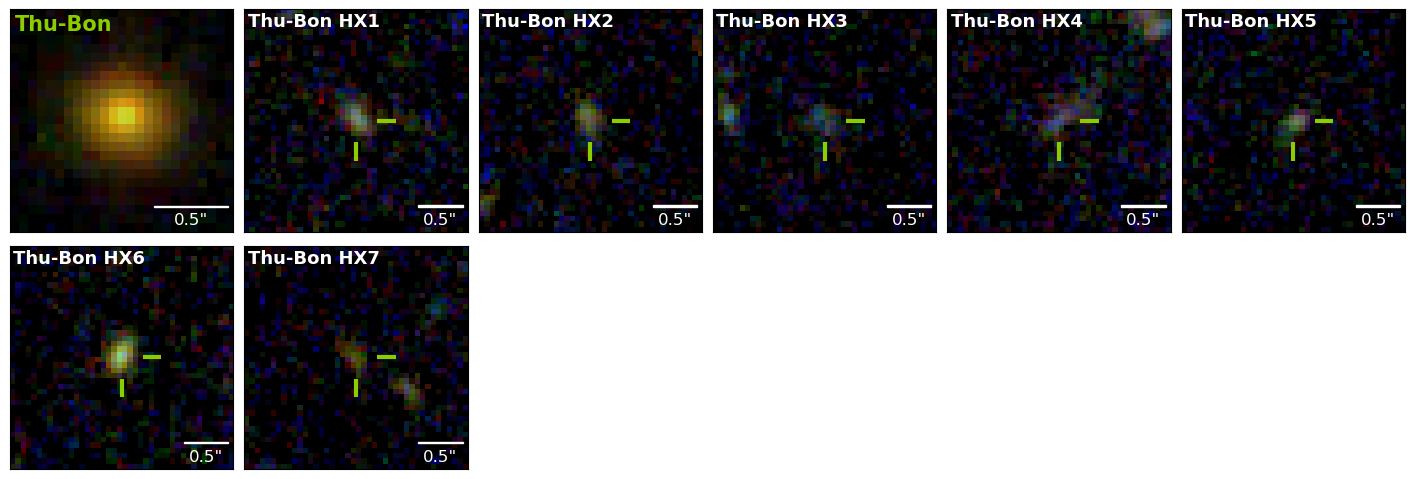

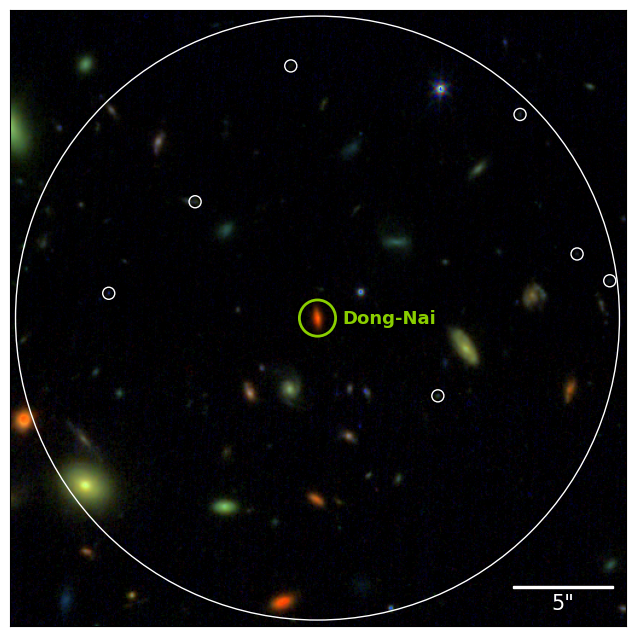

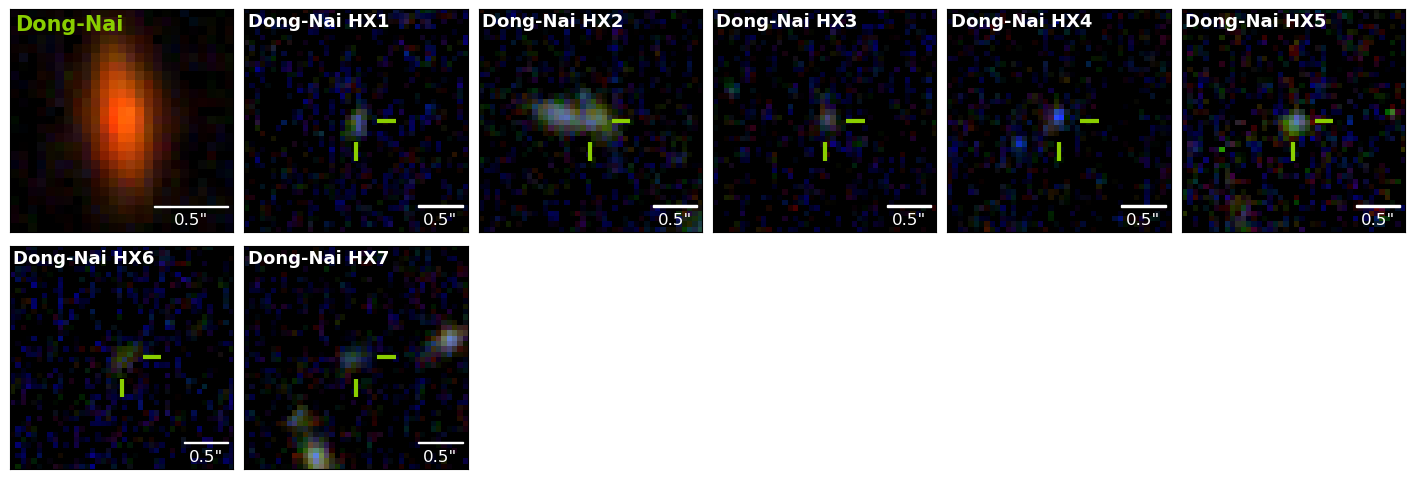

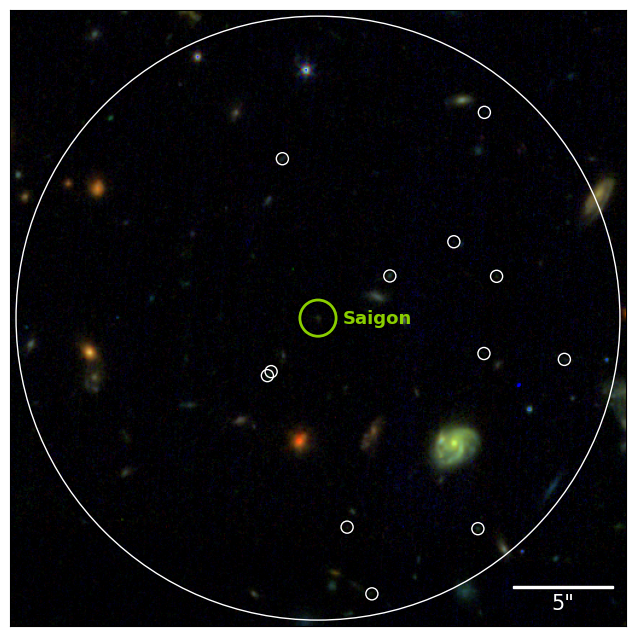

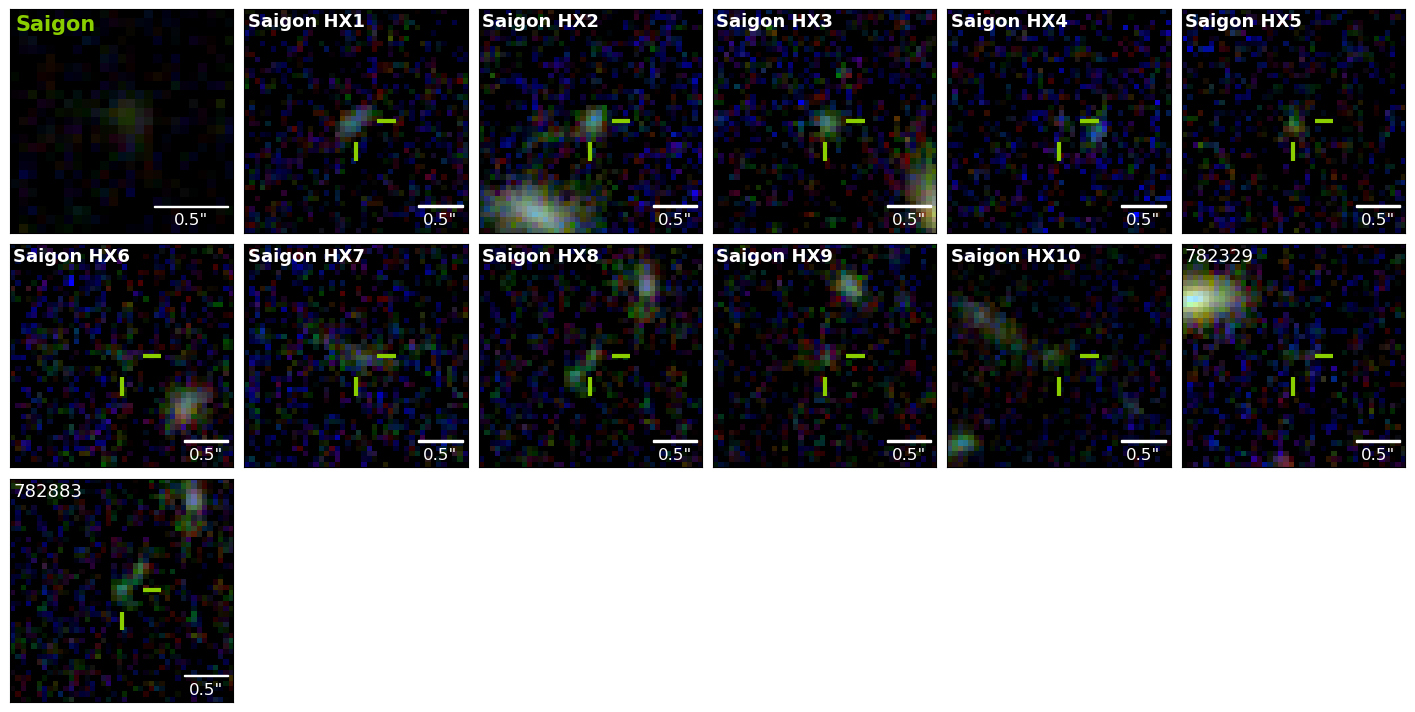

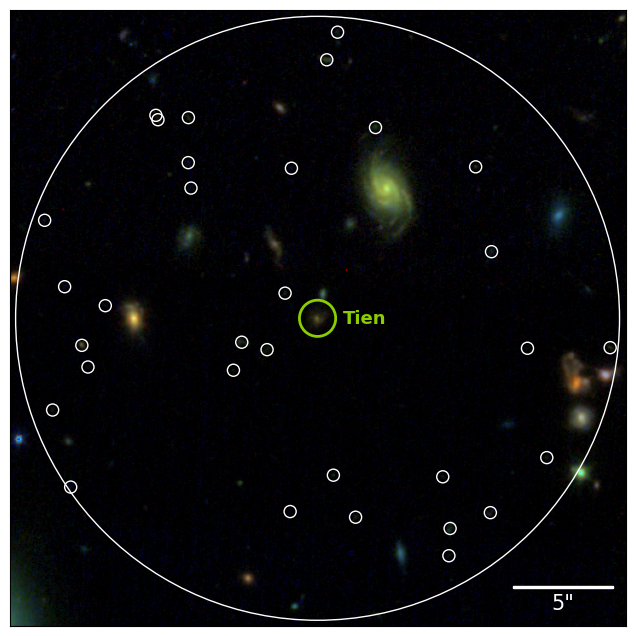

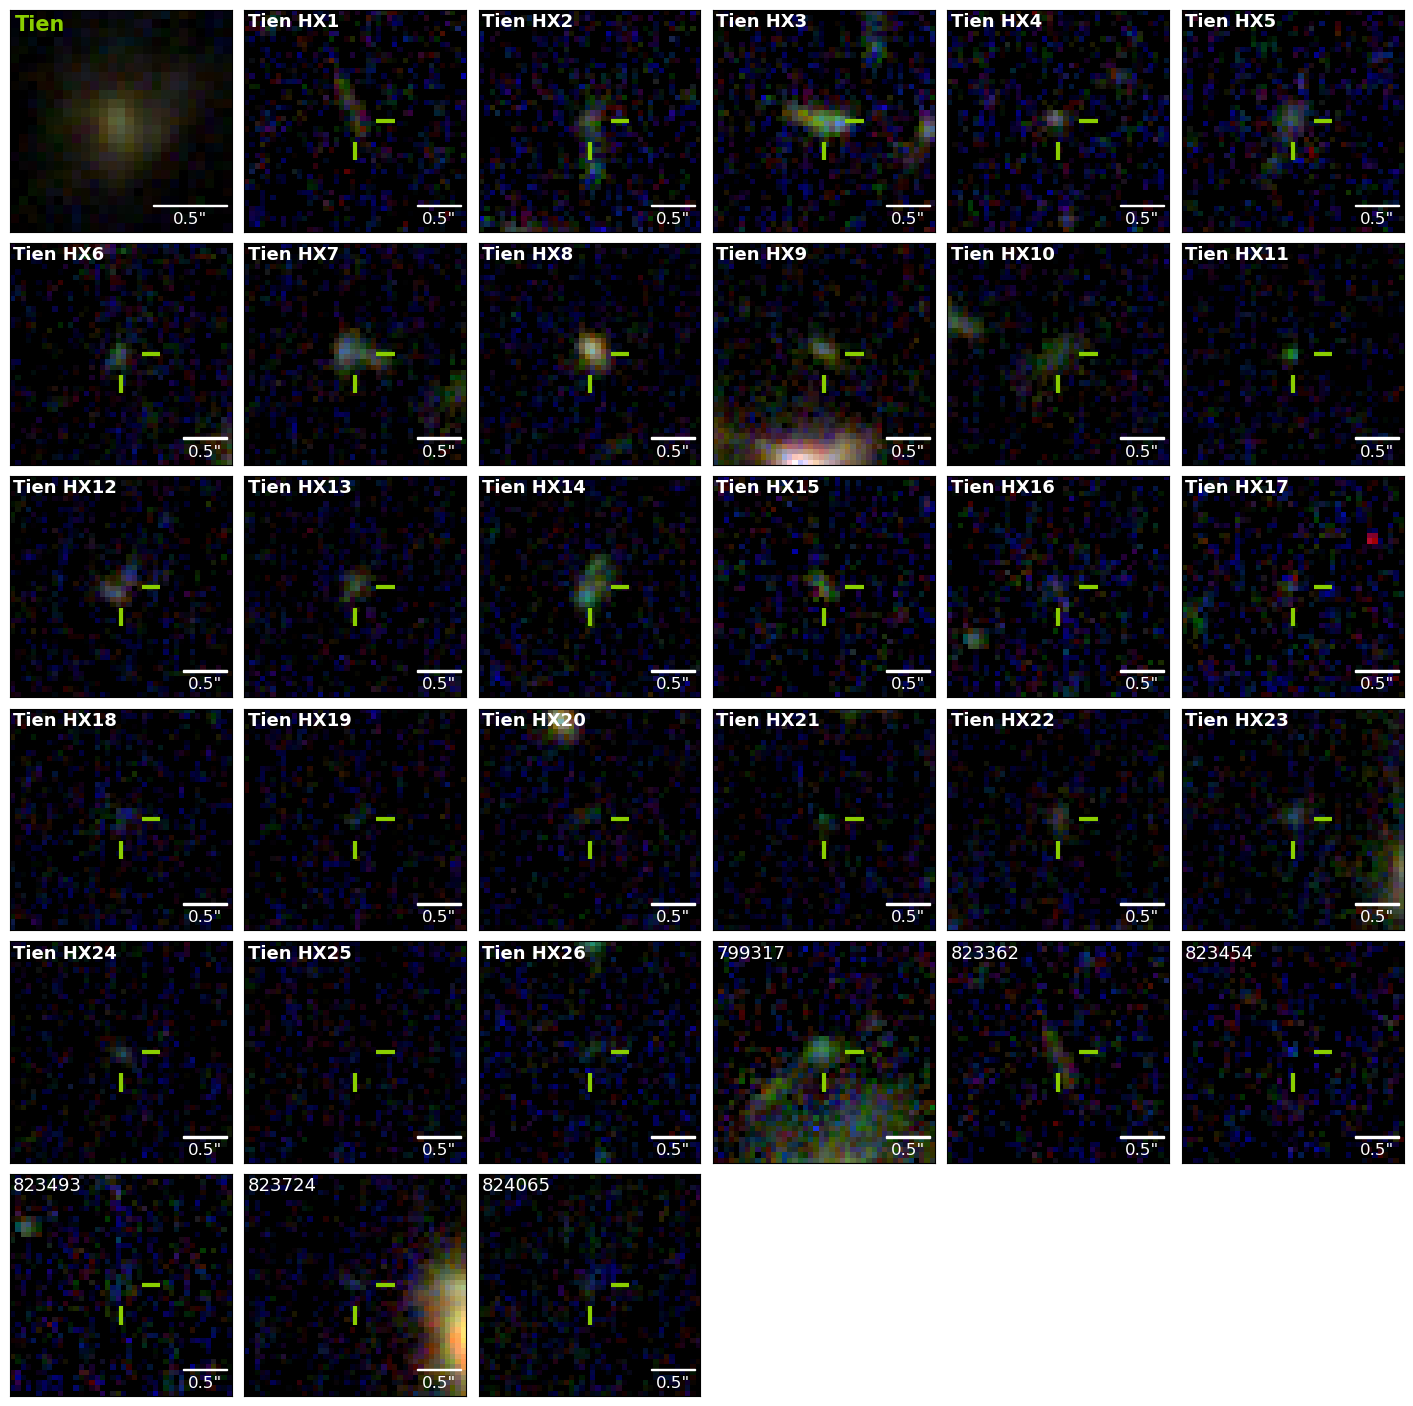

In [40]:
### This gigantic for-loop will loop over each of the 9 QGs in our sample. Their info is taken
### from the "info" array, which we have imported from the file basic_data.text above.
for our_galaxy in range(np.size(info)):
#for our_galaxy in range(1):

    ### This saves the name of the galaxy currently being looped through (henceforth called "our galaxy").
    ### NOTE: this name is the name assigned by us, based on the rivers of Vietnam.
    galaxy_name = info[our_galaxy][0]
    
    ### This selects a search radius for our galaxy based on the angular size.
    search_radius = angular_sizes[our_galaxy]
    
    ### This picks out the tile where our galaxy can be found.
    tile_search = our_tiles[our_galaxy]
    
    ### This creates an empty list to append RGB band datas into.
    ### The RGB bands are: F444W (red), F277W (green) and F150W (blue).
    ### NOTE: due to the order in nircam_bands, the order in this list will be flipped as BGR.
    ### This will serve the first type of postage stamps (the zoomed-out look).
    BGR_bands = []

    ### This creates an empty list for the same purpose and functions, but the images saved here 
    ### are more zoomed in. This will serve the second type of postage stamps.
    BGR_bands_subplot = []
    
    ### This creates empty lists to save the data of all the neighbors in each band.
    neighbor_f150w_bands = []
    neighbor_f277w_bands = []
    neighbor_f444w_bands = []
    
    ### Now, we make the aperture for each of the neighbors!
    # This reads in the RAs and Decs of all the neighbors around each galaxy.
    neigh_ra = np.array(sorted[sorted['our_id']==our_galaxy]['ra'])
    neigh_dec = np.array(sorted[sorted['our_id']==our_galaxy]['dec'])
    neigh_id = sorted[sorted['our_id']==our_galaxy]['id'].values

    # Sep 25, 2024: look for the specific tiles that have the outlier neighbors
    for id_name in neigh_id:
        if id_name in idx_cat:
            outlier_list.append(id_name)
            outlier_tile.append(tile_search)
        if id_name in idx_cat2:
            lephare_list.append(id_name)
            lephare_tile.append(tile_search)

    # This keeps track of the number of neighbors for each galaxy.
    number_of_nbrs = np.size(neigh_ra)
    
    ### NOW, let's loop over all the available bands for NIRCam!!!
    for i in range(1, how_many_bands):
        # This selects one of the bands to work with.
        band = nircam_bands[i]
        
        # This creates a path to lead the code to our fits file.
        our_file = '/Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_' + band + '_COSMOS-Web_60mas_' + tile_search + '_sci.fits'
        
        # This opens the fits file that matches the path above.
        file = fits.open(our_file)
        file.info()
            
        # This saves the WCS setting from the fits file to be used later.
        our_wcs = WCS(file[0].header)
        
        # This gets the data of the catalog.
        our_data = file[0].data
        
        # This closes the file to save up memory.
        file.close()
            
        # This sets a centering position based on the RA and Dec of our galaxy.
        position = SkyCoord(ra=galaxy_ra[our_galaxy]*u.degree, dec=galaxy_dec[our_galaxy]*u.degree)
            
        # This creates a cutout image. The additional factor of 2.04 is to make sure that the region is shown.
        cutout = Cutout2D(our_data, position, size=search_radius*2.04, wcs=our_wcs)

        # This creates a second cutout image that's more zoomed-in for the second type of postage stamps.
        cutout_subplot = Cutout2D(our_data, position, size=search_radius*0.1, wcs=our_wcs)
    
        # This saves the arrays if they're RGB bands (the latter three bands in our array)
        BGR_bands.append(cutout.data)
        BGR_bands_subplot.append(cutout_subplot.data)
    
        # This centers the galaxy, gets a cutout and saves the data of each neighbor in a specific band.
        for nbr in range(number_of_nbrs):
            neighbor_pos = SkyCoord(ra=neigh_ra[nbr]*u.degree, dec=neigh_dec[nbr]*u.degree)
            neighbor_cutout = Cutout2D(our_data, neighbor_pos, size=2.5*u.arcsec, wcs=our_wcs)
            if i == 1:
                neighbor_f150w_bands.append(neighbor_cutout.data)
            elif i == 2:
                neighbor_f277w_bands.append(neighbor_cutout.data)
            else:
                neighbor_f444w_bands.append(neighbor_cutout.data)
    
    ### This creates an RGB image.
    fig2, ax2 = plt.subplots(figsize=(8,8))
    RGB_image = make_lupton_rgb(BGR_bands[2], BGR_bands[1], BGR_bands[0], stretch=0.3)
    ax2.imshow(RGB_image)
    
    ### This creates the region that encompasses everything, including our galaxy and its neighbors.
    sky_region = CircleSkyRegion(position, search_radius)
    pixel_region = sky_region.to_pixel(wcs=cutout.wcs)
    pixel_region.plot(ax=ax2, color='white', lw=1.0)

    ### This further zones in on our central galaxy and creates a circle around it
    central_zoom = CircleSkyRegion(position, 0.9*u.arcsec)
    central_zoom_pixel = central_zoom.to_pixel(wcs=cutout.wcs)
    central_zoom_pixel.plot(ax=ax2, color='#8ACE00', lw=2.0)

    ### This gets the pixel scale of the postage stamp in arcsec
    pix_scale = (proj_plane_pixel_scales(cutout.wcs)[0]*u.deg).to(u.arcsec).value

    ### This adds a label next to the circle of the central galaxy
    ax2.text(275, 248, galaxy_name, horizontalalignment='left', verticalalignment='top', 
                    color='#8ACE00', fontsize=13, weight='bold')
    
    ### This plots a circle indicating the regions of all the neighbors.
    for idx in range(number_of_nbrs):
        nbr_pos = SkyCoord(ra=neigh_ra[idx]*u.degree, dec=neigh_dec[idx]*u.degree)
        aperture_size = Angle(0.3, 'arcsec')
        nbr_sky_region = CircleSkyRegion(nbr_pos, aperture_size)
        nbr_pixel_region = nbr_sky_region.to_pixel(wcs=cutout.wcs)
        nbr_pixel_region.plot(ax=ax2, color='white', lw=1.0)

        # NOTE: Undo this to get the IDs of all the neighbors (from Hollis' catalog) in the central galaxy's image.
        # Warning: they will look really ugly in the image.
        # text_pos = SkyCoord(ra=neigh_ra[idx]*u.degree, dec=(neigh_dec[idx]-1)*u.degree)
        # texts = TextSkyRegion(center=nbr_pos, text='  ' + str(neigh_id[idx]), visual=RegionVisual({'textangle': 30}))
        # texts_pixel = texts.to_pixel(wcs=cutout.wcs)
        # texts_pixel.plot(ax=ax2, color='white')

    ### This adds a scale bar
    fontprops = fm.FontProperties(size=15) # setting properties for the text under the scale bar
    scalebar = AnchoredSizeBar(ax2.transData, (5 / pix_scale), '5"', 'lower right', pad=0.5, color='white', sep=4,
                               frameon=False, size_vertical=2, fontproperties=fontprops)
    ax2.add_artist(scalebar)
    
    ### This removes the x and y tick labels
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    ### This saves the central galaxy's image
    fig2.savefig('visualizations/' + galaxy_name + '.png', bbox_inches='tight', dpi=1000)
    
    ### NOW, let's move on to the second type of postage stamps, which deals with 
    ### the subplots of the central galaxy and all its neighbors.
    # Set number of columns
    ncols = 6
    # Calculate number of rows
    nrows = (number_of_nbrs+1) // ncols + ((number_of_nbrs+1) % ncols > 0)
    
    ### This sets the plotting space, along with their width and height 
    ### based on the number of rows and columns picked.
    fig = plt.figure()
    fig.set_figwidth(ncols*3)
    fig.set_figheight(nrows*3)
    
    ### This makes sure the subplots are close together.
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    
    ### This gives the overall name for the figure of the subplots.
    fig.tight_layout()
    
    ### This loops over all the neighbors. "Number_of_nbrs + 1" to include 
    ### the central galaxy, which will be plotted as the first subplot as well.
    for index in range(number_of_nbrs+1):
        
        # Add a new subplot iteratively using nrows and cols.
        ax = plt.subplot(nrows, ncols, index+1)

        # Index 0 corresponds to the subplot of the central galaxy,
        # so this if-statement plots the zoomed-in central galaxy.
        if index == 0:
            central_RGB_image = make_lupton_rgb(BGR_bands_subplot[2], BGR_bands_subplot[1], BGR_bands_subplot[0], stretch=0.3)
            ax.imshow(central_RGB_image)

            # This adds a scale bar
            fontprops2 = fm.FontProperties(size=12) # setting properties for the text under the scale bar
            scalebar2 = AnchoredSizeBar(ax.transData, (0.5 / pix_scale), '0.5"', 'lower right', pad=0.2, color='white', sep=4,
                               frameon=False, size_vertical=0.1, fontproperties=fontprops2)
            ax.add_artist(scalebar2)

            # This removes the x and y tick labels.
            ax.set_xticks([])
            ax.set_yticks([])
        
            # This adds the name of the central galaxy to our image. The name will be brat-green
            # to be visibly distinguishable from the images of all the neighbors.
            ax.text(0.1, 0.1, str(galaxy_name), horizontalalignment='left', verticalalignment='top', 
                    color='#8ACE00', fontsize=15, weight='bold')

        # This plots all the zoomed-in neighbors.
        else:        
            # This creates an RGB image of each of the neighbors.
            nbr_RGB_image = make_lupton_rgb(neighbor_f444w_bands[index-1], neighbor_f277w_bands[index-1], 
                                            neighbor_f150w_bands[index-1], Q=5, stretch=0.1)
            
            ax.imshow(nbr_RGB_image)

            # This adds pointers as visual aids for the neighbors. The color is brat.
            ax.vlines(x=20.5, ymin=24.5, ymax=28, colors="#8ACE00", lw=3)
            ax.hlines(y=20.5, xmin=24.5, xmax=28, colors="#8ACE00", lw=3)

            # This adds a scale bar
            fontprops2 = fm.FontProperties(size=12) # setting properties for the text under the scale bar
            scalebar2 = AnchoredSizeBar(ax.transData, (0.5 / pix_scale), '0.5"', 'lower right', pad=0.2, color='white', sep=4,
                               frameon=False, size_vertical=0.3, fontproperties=fontprops2)
            ax.add_artist(scalebar2)
            
            # This removes the x and y tick labels.
            ax.set_xticks([])
            ax.set_yticks([])

            if sorted[sorted['id'] == neigh_id[index-1]]['nbr_name'].values != 'NA':
                nbr_name = sorted[sorted['id'] == neigh_id[index-1]]['nbr_name'].values[0]
                ax.text(0.1, 0.1, nbr_name, horizontalalignment='left', verticalalignment='top', 
                    color='white', fontsize=13, weight='bold')
            else:
                # This adds the ID of each neighbor (from Hollis' catalog) into the image.
                ax.text(0.1, 0.1, str(neigh_id[index-1]), horizontalalignment='left', verticalalignment='top', 
                    color='white', fontsize=13)
    
    ### This saves the figure with all the subplots of the neighbors.
    fig.savefig('visualizations/' + galaxy_name + '-and-nbrs.png', bbox_inches='tight', dpi=1000, transparent=True)

In [41]:
np.unique(idx_cat2)

array([756650, 756895, 758845, 759022, 759045, 759140, 759202, 759207,
       759334, 759455, 759460, 780830, 780870, 783764, 783888, 783964,
       784079, 784159, 784266, 784406, 784557, 784569, 784580, 784614,
       784646])

In [42]:
np.unique(np.array(lephare_list, dtype='object'))

array([756650, 756895, 758845, 759022, 759045, 759140, 759202, 759207,
       759334, 759455, 759460, 780830, 780870, 783764, 783888, 783964,
       784079, 784159, 784266, 784406, 784557, 784569, 784580, 784614,
       784646], dtype=object)

Sep 25, 2024: make postage stamps of the outliers.

Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_

Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-27T10:47:09.482' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.877923 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689690570.898 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-24T20:33:34.974' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.289' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE

Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B4_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B4_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_

Set DATE-AVG to '2024-01-02T11:26:42.626' from MJD-AVG.
Set DATE-END to '2024-01-06T17:28:50.910' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     9.002883 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696586013.959 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-01-02T12:01:20.603' from MJD-AVG.
Set DATE-END to '2024-01-06T18:03:33.852' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.998031 from OBSGEO-[XYZ].
Set OBSGEO-H to 1696584712.167 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-27T10:47:09.482' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.877923 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689690570.898 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE

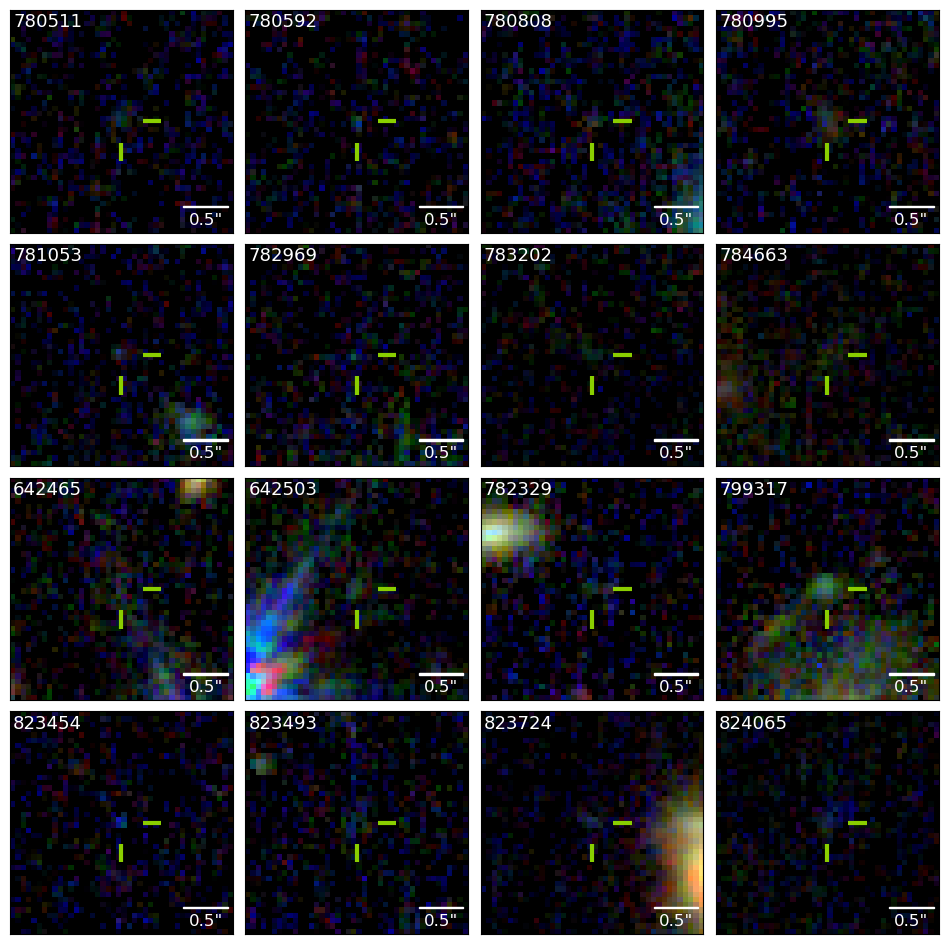

In [44]:
### This gigantic for-loop will loop over each of the 9 QGs in our sample. Their info is taken
### from the "info" array, which we have imported from the file basic_data.text above.

### This creates empty lists to save the data of all the neighbors in each band.
outlier_f150w_bands = []
outlier_f277w_bands = []
outlier_f444w_bands = []

for q in range(len(outlier_list)):
    outlier_id = outlier_list[q]
    tile = outlier_tile[q]

    outlier_ra = full_data[full_data['id']==outlier_id]['ra'].values
    outlier_dec = full_data[full_data['id']==outlier_id]['dec'].values
    
    ### NOW, let's loop over all the available bands for NIRCam!!!
    for i in range(1, how_many_bands):
        # This selects one of the bands to work with.
        band = nircam_bands[i]
        
        # This creates a path to lead the code to our fits file.
        our_file = '/Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_' + band + '_COSMOS-Web_60mas_' + tile + '_sci.fits'
        
        # This opens the fits file that matches the path above.
        file = fits.open(our_file)
        file.info()
            
        # This saves the WCS setting from the fits file to be used later.
        our_wcs = WCS(file[0].header)
        
        # This gets the data of the catalog.
        our_data = file[0].data
        
        # This closes the file to save up memory.
        file.close()
            
        # This sets a centering position based on the RA and Dec of our galaxy.
        position = SkyCoord(ra=outlier_ra*u.degree, dec=outlier_dec*u.degree)
            
        # This creates a cutout image. The additional factor of 2.04 is to make sure that the region is shown.
        cutout = Cutout2D(our_data, position, size=2.5*u.arcsec, wcs=our_wcs)
        
        if i == 1:
            outlier_f150w_bands.append(cutout.data)
        elif i == 2:
            outlier_f277w_bands.append(cutout.data)
        else:
            outlier_f444w_bands.append(cutout.data)

### NOW, let's plot
# Set number of columns
ncols = 4
# Calculate number of rows
nrows = 4
    
### This sets the plotting space, along with their width and height 
### based on the number of rows and columns picked.
fig = plt.figure()
fig.set_figwidth(ncols*3)
fig.set_figheight(nrows*3)

### This makes sure the subplots are close together.
fig.subplots_adjust(wspace=0.05, hspace=0.05)
    
### This gives the overall name for the figure of the subplots.
fig.tight_layout()
    
### This loops over all the outliers
for digit in range(len(outlier_list)):
    
    # Add a new subplot iteratively using nrows and cols.
    ax = plt.subplot(nrows, ncols, digit+1)

    # This creates an RGB image of each of the outliers.
    nbr_RGB_image = make_lupton_rgb(outlier_f444w_bands[digit], outlier_f277w_bands[digit], 
                                            outlier_f150w_bands[digit], Q=5, stretch=0.1)
            
    ax.imshow(nbr_RGB_image)

    # This adds pointers as visual aids for the neighbors. The color is brat.
    ax.vlines(x=20.5, ymin=24.5, ymax=28, colors="#8ACE00", lw=3)
    ax.hlines(y=20.5, xmin=24.5, xmax=28, colors="#8ACE00", lw=3)

    # This adds a scale bar
    fontprops2 = fm.FontProperties(size=12) # setting properties for the text under the scale bar
    scalebar2 = AnchoredSizeBar(ax.transData, (0.5 / pix_scale), '0.5"', 'lower right', pad=0.2, color='white', sep=4,
                               frameon=False, size_vertical=0.3, fontproperties=fontprops2)
    ax.add_artist(scalebar2)
            
    # This removes the x and y tick labels.
    ax.set_xticks([])
    ax.set_yticks([])
        
    # This adds the ID of each neighbor (from Hollis' catalog) into the image.
    ax.text(0.1, 0.1, str(outlier_list[digit]), horizontalalignment='left', verticalalignment='top', 
                    color='white', fontsize=13)

fig.savefig('visualizations/16_outliers.png', bbox_inches='tight', dpi=1000)

Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_

Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-27T10:47:09.482' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.877923 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689690570.898 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-24T20:33:34.974' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.289' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE

Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_

Set DATE-AVG to '2023-08-24T20:33:34.974' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.289' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-27T10:47:09.482' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.877923 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689690570.898 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-24T20:33:34.974' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.289' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE

Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f444w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f150w_COSMOS-Web_60mas_B7_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      73   (9600, 12455)   float32   
Filename: /Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_f277w_COSMOS-Web_60mas_B7_

Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-27T10:47:09.482' from MJD-AVG.
Set DATE-END to '2024-01-06T13:45:27.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.877923 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689690570.898 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-08-24T20:33:34.974' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.289' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.955753 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686788846.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-02T04:30:47.638' from MJD-AVG.
Set DATE-END to '2024-01-06T14:20:21.225' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.880441 from OBSGEO-[XYZ].
Set OBSGEO-H to 1689561270.072 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE

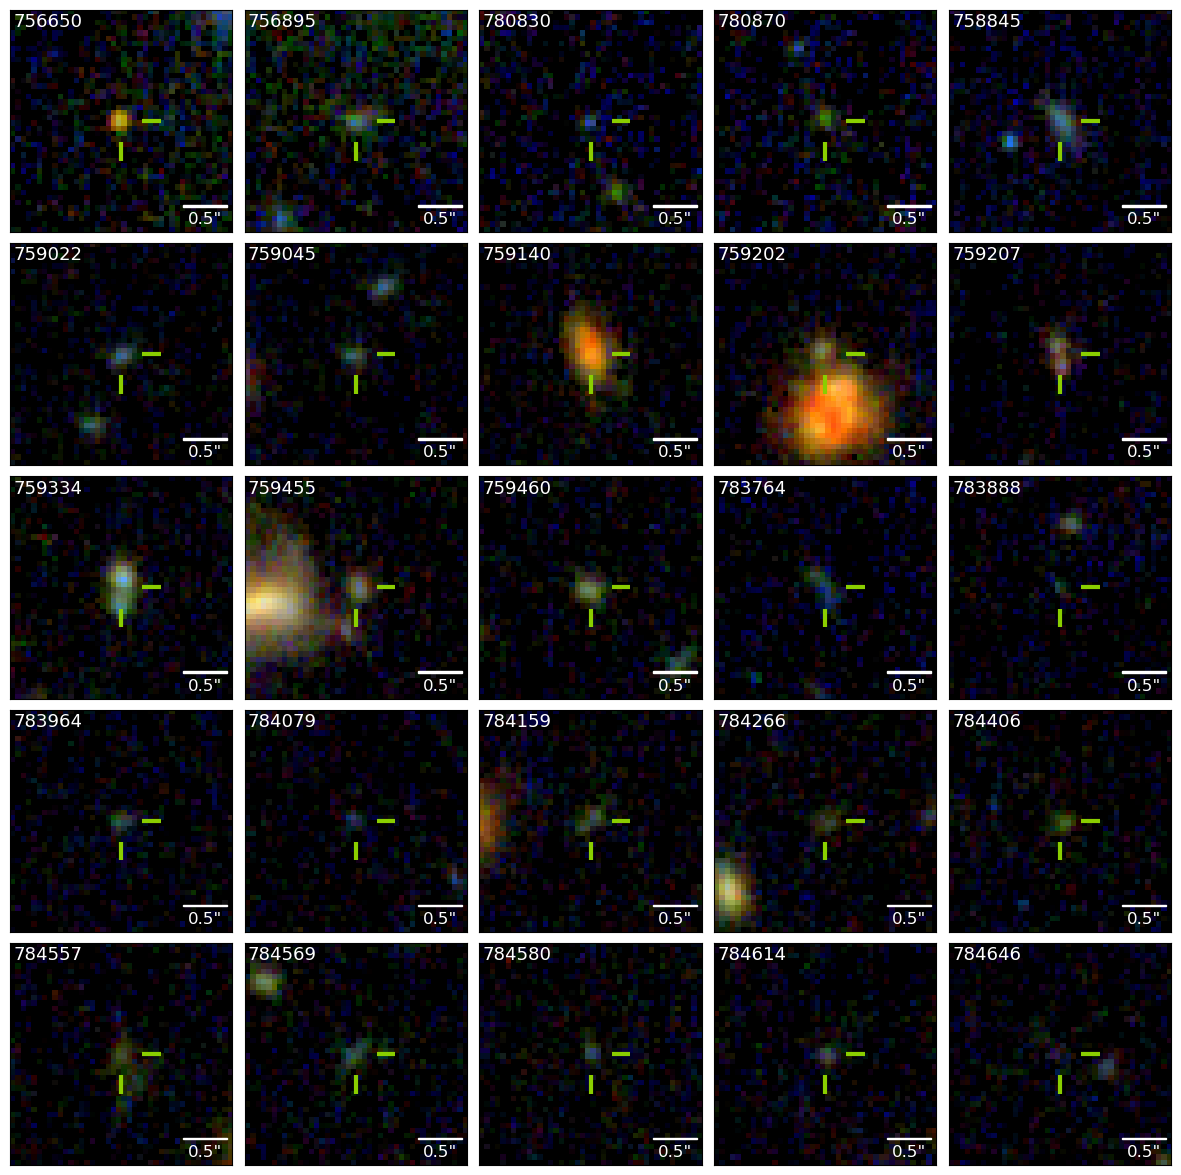

In [45]:
### This gigantic for-loop will loop over each of the 9 QGs in our sample. Their info is taken
### from the "info" array, which we have imported from the file basic_data.text above.

### This creates empty lists to save the data of all the neighbors in each band.
lephare_f150w_bands = []
lephare_f277w_bands = []
lephare_f444w_bands = []

for q in range(len(lephare_list)):
    lephare_id = lephare_list[q]
    tile = lephare_tile[q]

    lephare_ra = full_data[full_data['id']==lephare_id]['ra'].values
    lephare_dec = full_data[full_data['id']==lephare_id]['dec'].values
    
    ### NOW, let's loop over all the available bands for NIRCam!!!
    for i in range(1, how_many_bands):
        # This selects one of the bands to work with.
        band = nircam_bands[i]
        
        # This creates a path to lead the code to our fits file.
        our_file = '/Volumes/LaCie/COSMOS_DATA/cweb_tiles/mosaic_nircam_' + band + '_COSMOS-Web_60mas_' + tile + '_sci.fits'
        
        # This opens the fits file that matches the path above.
        file = fits.open(our_file)
        file.info()
            
        # This saves the WCS setting from the fits file to be used later.
        our_wcs = WCS(file[0].header)
        
        # This gets the data of the catalog.
        our_data = file[0].data
        
        # This closes the file to save up memory.
        file.close()
            
        # This sets a centering position based on the RA and Dec of our galaxy.
        position = SkyCoord(ra=lephare_ra*u.degree, dec=lephare_dec*u.degree)
            
        # This creates a cutout image. The additional factor of 2.04 is to make sure that the region is shown.
        cutout = Cutout2D(our_data, position, size=2.5*u.arcsec, wcs=our_wcs)
        
        if i == 1:
            lephare_f150w_bands.append(cutout.data)
        elif i == 2:
            lephare_f277w_bands.append(cutout.data)
        else:
            lephare_f444w_bands.append(cutout.data)

### NOW, let's plot
# Set number of columns
ncols = 5
# Calculate number of rows
nrows = 5
    
### This sets the plotting space, along with their width and height 
### based on the number of rows and columns picked.
fig = plt.figure()
fig.set_figwidth(ncols*3)
fig.set_figheight(nrows*3)

### This makes sure the subplots are close together.
fig.subplots_adjust(wspace=0.05, hspace=0.05)
    
### This gives the overall name for the figure of the subplots.
fig.tight_layout()
    
### This loops over all the LePhare objects
for digit in range(len(lephare_list)):
    
    # Add a new subplot iteratively using nrows and cols.
    ax = plt.subplot(nrows, ncols, digit+1)

    # This creates an RGB image of each of the LePhare objects.
    nbr_RGB_image = make_lupton_rgb(lephare_f444w_bands[digit], lephare_f277w_bands[digit], 
                                            lephare_f150w_bands[digit], Q=5, stretch=0.1)
            
    ax.imshow(nbr_RGB_image)

    # This adds pointers as visual aids for the neighbors. The color is brat.
    ax.vlines(x=20.5, ymin=24.5, ymax=28, colors="#8ACE00", lw=3)
    ax.hlines(y=20.5, xmin=24.5, xmax=28, colors="#8ACE00", lw=3)

    # This adds a scale bar
    fontprops2 = fm.FontProperties(size=12) # setting properties for the text under the scale bar
    scalebar2 = AnchoredSizeBar(ax.transData, (0.5 / pix_scale), '0.5"', 'lower right', pad=0.2, color='white', sep=4,
                               frameon=False, size_vertical=0.3, fontproperties=fontprops2)
    ax.add_artist(scalebar2)
            
    # This removes the x and y tick labels.
    ax.set_xticks([])
    ax.set_yticks([])
        
    # This adds the ID of each neighbor (from Hollis' catalog) into the image.
    ax.text(0.1, 0.1, str(lephare_list[digit]), horizontalalignment='left', verticalalignment='top', 
                    color='white', fontsize=13)

fig.savefig('visualizations/25_flag1.png', bbox_inches='tight', dpi=1000)